# Energy Allocation

In [1]:
#using Pkg
#Pkg.add("XLSX")

In [1]:
using XLSX, Gurobi, StatsBase, CSV, DataFrames, 
JuMP, LinearAlgebra, Distributions, Random,
GLMNet, ScikitLearn, MLBase, CategoricalArrays, Plots,
Dates, Clustering, Distances, StatsPlots, ProgressMeter, 
StableRNGs, ParallelKMeans, JuMP, Gurobi

In [2]:
# Read xlsm file
initial_df = DataFrame(XLSX.readtable("eCO2mix_RTE_Annuel-Definitif_2020.xlsm", "eCO2mix_RTE_Annuel-Definitif_20"));
seed = 1234;

In [3]:
# Let's clean the data

# Remove all rows with missing values
df = dropmissing(initial_df, disallowmissing=true);

# remove every columns before the Date column and after the Ech. comm. Allemagne-Belgique column
df = df[:, 3:23]

# put the columns PrÈvision J-1, PrÈvision J, Pompage, Ech. physiques
prev_pomp_df = df[:, [4, 5, 13, 15]]
# drom column 4,5,13,15
df = df[:, Not([4, 5, 13, 15])]

# rename the columns
rename!(df, Symbol.(["Date", "Time", "Consumption", "Fuel", "Coal", "Gas", "Nuclear", "Wind", "Solar", "Hydraulic", "Bioenergy", "CO2", "England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]))

# for each country, we will divide in import and export, depending on the sign of the corresponding column

neighbors_columns = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]
for col in neighbors_columns
    # create a new import column, which values are positive if the original column is positive, and 0 otherwise
    df[!, Symbol(col * "_import")] = max.(df[!, Symbol(col)], 0)
    # create a new export column, which values are positive if the original column is negative, and 0 otherwise
    df[!, Symbol(col * "_export")] = max.(-df[!, Symbol(col)], 0)
end

# drop the original columns
df = df[:, Not(neighbors_columns)]


# convert the date column to a string
df[!, :Date] = string.(df[!, :Date])
# convert the time column to a string
df[!, :Time] = string.(df[!, :Time])
# merge the date and time columns into a single column
df[!, :DateTime] = df[!, :Date] .* " " .* df[!, :Time]
# convert the DateTime column to a DateTime type
df[!, :DateTime] = DateTime.(df[!, :DateTime], "yyyy-mm-dd HH:MM:SS")
# convert date and time columns to a DateTime type
df[!, :Date] = Date.(df[!, :Date], "yyyy-mm-dd")
df[!, :Time] = Time.(df[!, :Time], "HH:MM:SS")

# sort the dataframe by DateTime
df = sort(df, :DateTime)
# put the DateTime column as the first column
df = df[:, [end; 1:end-1]]

# the units are in MWh
# convert the Any type to Float64
df[!, :Consumption] = convert(Array{Float64}, df[!, :Consumption])
df[!, :Fuel] = convert(Array{Float64}, df[!, :Fuel])
df[!, :Coal] = convert(Array{Float64}, df[!, :Coal])
df[!, :Gas] = convert(Array{Float64}, df[!, :Gas])
df[!, :Nuclear] = convert(Array{Float64}, df[!, :Nuclear])
df[!, :Wind] = convert(Array{Float64}, df[!, :Wind])
df[!, :Solar] = convert(Array{Float64}, df[!, :Solar])
df[!, :Hydraulic] = convert(Array{Float64}, df[!, :Hydraulic])
df[!, :Bioenergy] = convert(Array{Float64}, df[!, :Bioenergy])
df[!, :CO2] = convert(Array{Float64}, df[!, :CO2])
df[!, :England_import] = convert(Array{Float64}, df[!, :England_import])
df[!, :England_export] = convert(Array{Float64}, df[!, :England_export])
df[!, :Spain_import] = convert(Array{Float64}, df[!, :Spain_import])
df[!, :Spain_export] = convert(Array{Float64}, df[!, :Spain_export])
df[!, :Italy_import] = convert(Array{Float64}, df[!, :Italy_import])
df[!, :Italy_export] = convert(Array{Float64}, df[!, :Italy_export])
df[!, :Switzerland_import] = convert(Array{Float64}, df[!, :Switzerland_import])
df[!, :Switzerland_export] = convert(Array{Float64}, df[!, :Switzerland_export])
df[!, :Germany_Belgium_import] = convert(Array{Float64}, df[!, :Germany_Belgium_import])
df[!, :Germany_Belgium_export] = convert(Array{Float64}, df[!, :Germany_Belgium_export]);


### Pre-processing

In [4]:
Random.seed!(seed)

function transform_data(df; push_nuclear=0.2, push_solar=0.15)
    Random.seed!(seed)
    inc_nuc = 1 + push_nuclear
    inc_sol = 1 + push_solar
    
    # get max value of nuclear production overall
    max_nuclear = maximum(df[!, :Nuclear])
    df[!, :Nuclear_cap] = fill(max_nuclear* inc_nuc, size(df[!, :Nuclear]))
    #max_hydraulic = maximum(df[!, :Hydraulic])
    #df[!, :Hydraulic_cap] = fill(max_hydraulic* inc_nuc, size(df[!, :Hydraulic]))
    max_bioenergy = maximum(df[!, :Bioenergy])
    df[!, :Bioenergy_cap] = fill(max_bioenergy* inc_nuc, size(df[!, :Bioenergy]))


    df[!, :Week] = Dates.week.(df[!, :Date])
    # get the average production of gas, coal, fuel, solar and wind (and the maximum for hydraulic) for each week of the year in one dataframe
    df_weekly = combine(groupby(df, :Week), :Solar => mean => :Solar_cap, :Wind => mean => :Wind_cap, :Gas => mean => :Gas_cap, :Coal => mean => :Coal_cap, :Fuel => mean => :Fuel_cap, :Hydraulic => mean => :Hydraulic_cap)
    # sort the dataframe by week
    df_weekly = sort(df_weekly, :Week)
    # add 20% to each column of df_weekly
    df_weekly[!, :Solar_cap] = df_weekly[!, :Solar_cap] * inc_sol
    df_weekly[!, :Wind_cap] = df_weekly[!, :Wind_cap] * inc_sol
    df_weekly[!, :Gas_cap] = df_weekly[!, :Gas_cap] * inc_sol
    df_weekly[!, :Coal_cap] = df_weekly[!, :Coal_cap] * inc_sol
    df_weekly[!, :Fuel_cap] = df_weekly[!, :Fuel_cap] * inc_sol
    
    df_weekly[!, :Hydraulic_cap] = df_weekly[!, :Hydraulic_cap] * inc_nuc
    # sort the dataframe by week
    df_weekly = sort(df_weekly, :Week)
    # merge the two dataframes df and df_weekly on week column
    df = leftjoin(df, df_weekly, on=:Week)

    cost_nuclear = 59.8:2:109.8
    cost_wind = 90:1:90
    cost_hydraulic = 15:0.5:20
    cost_solar = 142:1:142
    cost_gas = 70:2:100
    cost_coal = 100:1:100
    cost_fuel = 86:1:86
    cost_bioenergy = 85:2:122

    # create a vector of size 53 for each type of energy cost with random values in the range defined above
    cost_nuclear = rand(cost_nuclear, 53)
    # vary the costs with a random number in the std of the range of values
    cost_nuclear = cost_nuclear .+ randn(53) * std(cost_nuclear)

    cost_hydraulic = rand(cost_hydraulic, 53)
    cost_hydraulic = cost_hydraulic .+ randn(53) * std(cost_hydraulic)

    cost_gas = rand(cost_gas, 53)
    cost_gas = cost_gas .+ randn(53) * std(cost_gas)

    cost_bioenergy = rand(cost_bioenergy, 53)
    cost_bioenergy = cost_bioenergy .+ randn(53) * std(cost_bioenergy)

    cost_wind = rand(cost_wind, 53)
    cost_wind = cost_wind .+ randn(53) * std(cost_wind)

    cost_solar = rand(cost_solar, 53)
    cost_solar = cost_solar .+ randn(53) * std(cost_solar)

    cost_coal = rand(cost_coal, 53)
    cost_coal = cost_coal .+ randn(53) * std(cost_coal)

    cost_fuel = rand(cost_fuel, 53)
    cost_fuel = cost_fuel .+ randn(53) * std(cost_fuel)

    # create a dataframe with the cost of each type of energy
    df_cost = DataFrame(Week = 1:53, Nuclear_cost = cost_nuclear, Wind_cost = cost_wind, Solar_cost = cost_solar, Gas_cost = cost_gas, Coal_cost = cost_coal, Fuel_cost = cost_fuel, Hydraulic_cost = cost_hydraulic, Bioenergy_cost = cost_bioenergy)

    # sort the dataframe by week
    df_cost = sort(df_cost, :Week)

    # merge the two dataframes df and df_cost on week column
    df = leftjoin(df, df_cost, on=:Week)

    

    df[!, :Total_cost] = (df[!, :Nuclear] .* df[!, :Nuclear_cost] .+ df[!, :Wind] .* df[!, :Wind_cost] .+ df[!, :Solar] .* df[!, :Solar_cost] .+ df[!, :Gas] .* df[!, :Gas_cost] .+ df[!, :Coal] .* df[!, :Coal_cost] .+ df[!, :Fuel] .* df[!, :Fuel_cost] .+ df[!, :Hydraulic] .* df[!, :Hydraulic_cost] .+ df[!, :Bioenergy] .* df[!, :Bioenergy_cost]) ./ (df[!, :Nuclear] .+ df[!, :Wind] .+ df[!, :Solar] .+ df[!, :Gas] .+ df[!, :Coal] .+ df[!, :Fuel] .+ df[!, :Hydraulic] .+ df[!, :Bioenergy])
    # Create a column called "Export_Price" which is the Total_cost + (10 plus or minus 3%, randomly)
    df[!, :Export_Price] = df[!, :Total_cost] .+ (df[!, :Total_cost] .* (0.1 .+ randn(size(df)[1]) * 0.03))

    # Create a column called "England_Price"
    # It is equal to 1000 if England_import==0 and Export_Price minus (10% plus or minus 3%) otherwise
    df[!, :England_Price] = ifelse.(df[!, :England_import] .== 0, 1000, df[!, :Export_Price] .- (df[!, :Export_Price] .* (0.1 .+ randn(size(df)[1]) * 0.03)))
    df[!, :Spain_Price] = ifelse.(df[!, :Spain_import] .== 0, 1000, df[!, :Export_Price] .- (df[!, :Export_Price] .* (0.15 .+ randn(size(df)[1]) * 0.03)))
    df[!, :Italy_Price] = ifelse.(df[!, :Italy_import] .== 0, 1000, df[!, :Export_Price] .- (df[!, :Export_Price] .* (0.07 .+ randn(size(df)[1]) * 0.03)))
    df[!, :Switzerland_Price] = ifelse.(df[!, :Switzerland_import] .== 0, 1000, df[!, :Export_Price] .- (df[!, :Export_Price] .* (0.1 .+ randn(size(df)[1]) * 0.03)))
    df[!, :Germany_Belgium_Price] = ifelse.(df[!, :Germany_Belgium_import] .== 0, 1000, df[!, :Export_Price] .- (df[!, :Export_Price] .* (0.2 .+ randn(size(df)[1]) * 0.03)))

    return df
end

transform_data (generic function with 1 method)

### Eco-cost synthetic data

For each source s, at each time t, we need an Eco-cost $f_{s,t}$

In [5]:
Eco_cost_footprint = [0.0347, 0.0003, 0.0175, 0.0003, 0.0281, 0.0002, 0.0030, 0.0164, 0.0130, 0.0193, 0.0172, 0.0067, 0.0226, 0.0065, 0.0109, 0.0024, 0.0136, 0.0099, 0.0154, 0.0270, 0.0099, 0.0095, 0.0084, 0.0006, 0.0091, 0.0156]
carbon_footprint_equiv = [0.30, 0.0023, 0.15, 0.00, 0.24, 0.0017, 0.03, 0.14, 0.11, 0.17, 0.15, 0.06, 0.19, 0.06, 0.09, 0.02, 0.12, 0.09, 0.13, 0.23, 0.08, 0.08, 0.07, 0.01, 0.08, 0.13]

# compute the mean of carbon_footprint_equiv / Eco_cost_footprint
mean_Eco_cost_carbon_footprint_equiv =  1 / mean(carbon_footprint_equiv ./ Eco_cost_footprint)

0.11652081241930631

In [6]:
function compute_eco_costs(df)

    # compute mean of CO2 column in different units
    CO2 = df[!, :CO2]
    mean_CO2 = mean(CO2)
    mean_CO2_GJ = mean_CO2 * 3.6

    # add values human_health, eco_toxicity, resource_scarcity, carbon_footprint for each source of energy, based on US Idemat Data
    fuel_info = [0.00246, 0.00821, 0.00007, 0.0281]
    coal_info = [0.00340, 0.00497, 0.00046, 0.0347]
    gas_info = [0.00324, 0.00294, 0.00013, 0.0175]
    nuclear_info = [0.00008, 0.00051, 0.03812, 0.0003]

    # we approximate all renewable energy sources with the same values
    hydraulic_info = [0.00002, 0.00003, 0.00017, 0.0002]
    bioenergy_info = [0.00002, 0.00003, 0.00017, 0.0002]
    wind_info = [0.00002, 0.00003, 0.00017, 0.0002]
    solar_info = [0.00002, 0.00003, 0.00017, 0.0002]

    # get the mean production of each source of energy
    mean_hydraulic = mean(df[!, :Hydraulic])
    mean_bioenergy = mean(df[!, :Bioenergy])
    mean_wind = mean(df[!, :Wind])
    mean_solar = mean(df[!, :Solar])
    mean_nuclear = mean(df[!, :Nuclear])
    mean_gas = mean(df[!, :Gas])
    mean_coal = mean(df[!, :Coal])
    mean_fuel = mean(df[!, :Fuel])

    # get the percentage of use of each source of energy
    total_production = mean_hydraulic + mean_bioenergy + mean_wind + mean_solar + mean_nuclear + mean_gas + mean_coal + mean_fuel
    percentage_hydraulic = mean_hydraulic / total_production
    percentage_bioenergy = mean_bioenergy / total_production
    percentage_wind = mean_wind / total_production
    percentage_solar = mean_solar / total_production
    percentage_nuclear = mean_nuclear / total_production
    percentage_gas = mean_gas / total_production
    percentage_coal = mean_coal / total_production
    percentage_fuel = mean_fuel / total_production

    # sum infos using the percentage of use of each source of energy
    sum_info = percentage_hydraulic * hydraulic_info + percentage_bioenergy * bioenergy_info + percentage_wind * wind_info + percentage_solar * solar_info + percentage_nuclear * nuclear_info + percentage_gas * gas_info + percentage_coal * coal_info + percentage_fuel * fuel_info;


    idemat_eco_cost_per_GJ = 18.19 # in euros/GJ
    idemat_carbon_footprint_per_GJ = 20.40 # in kg/GJ

    idemat_eco_costs = [0.21, 0.78, 14.83, 2.37] # in euros/GJ
    idemat_proportions = idemat_eco_costs / sum(idemat_eco_costs)
    # for each value in sum_info, determine the percentage of use of each source of energy

    # percentages of impact of each source of energy on eco_cost
    percentages_hydraulic = percentage_hydraulic .* hydraulic_info ./ sum_info .* idemat_proportions
    percentages_bioenergy = percentage_bioenergy .* bioenergy_info ./ sum_info .* idemat_proportions
    percentages_wind = percentage_wind .* wind_info ./ sum_info .* idemat_proportions
    percentages_solar = percentage_solar .* solar_info ./ sum_info .* idemat_proportions
    percentages_nuclear = percentage_nuclear .* nuclear_info ./ sum_info .* idemat_proportions
    percentages_gas = percentage_gas .* gas_info ./ sum_info .* idemat_proportions
    percentages_coal = percentage_coal .* coal_info ./ sum_info .* idemat_proportions
    percentages_fuel = percentage_fuel .* fuel_info ./ sum_info .* idemat_proportions


    idemat_eco_cost_per_MWh = idemat_eco_cost_per_GJ  / 3.6
    idemat_carbon_footprint_per_MWh = idemat_carbon_footprint_per_GJ / 3.6

    real_eco_cost_per_MWh = idemat_eco_cost_per_MWh / idemat_carbon_footprint_per_MWh * mean_CO2
    real_eco_costs = idemat_proportions * real_eco_cost_per_MWh # in euros/MWh

    # in euros/MWh
    eco_costs_hydraulic = percentages_hydraulic .* real_eco_cost_per_MWh
    eco_costs_bioenergy = percentages_bioenergy .* real_eco_cost_per_MWh
    eco_costs_wind = percentages_wind .* real_eco_cost_per_MWh
    eco_costs_solar = percentages_solar .* real_eco_cost_per_MWh
    eco_costs_nuclear = percentages_nuclear .* real_eco_cost_per_MWh
    eco_costs_gas = percentages_gas .* real_eco_cost_per_MWh
    eco_costs_coal = percentages_coal .* real_eco_cost_per_MWh
    eco_costs_fuel = percentages_fuel .* real_eco_cost_per_MWh

    Hydraulic_Eco_cost = sum(eco_costs_hydraulic)
    Bioenergy_Eco_cost = sum(eco_costs_bioenergy)
    Wind_Eco_cost = sum(eco_costs_wind)
    Solar_Eco_cost = sum(eco_costs_solar)
    Nuclear_Eco_cost = sum(eco_costs_nuclear)
    Gas_Eco_cost = sum(eco_costs_gas)
    Coal_Eco_cost = sum(eco_costs_coal)
    Fuel_Eco_cost = sum(eco_costs_fuel)

    # create a little dataframe with the results
    eco_costs = DataFrame(Source = ["Hydraulic", "Bioenergy", "Wind", "Solar", "Nuclear", "Gas", "Coal", "Fuel"],
        Eco_cost = [Hydraulic_Eco_cost, Bioenergy_Eco_cost, Wind_Eco_cost, Solar_Eco_cost, Nuclear_Eco_cost, Gas_Eco_cost, Coal_Eco_cost, Fuel_Eco_cost])
    
    # sort the dataframe by the eco_cost
    eco_costs = eco_costs[sortperm(eco_costs.Eco_cost), :]

    # return the dataframe
    return eco_costs
end

compute_eco_costs (generic function with 1 method)

In [7]:
function compute_carbon_footprints(df)
    # in kg/MWh
    nuclear_footprint_estimates = [0.006, 0.006] * 1000
    hydraulic_footprint_estimates = [0.006, 0.004] * 1000
    wind_footprint_estimates = [0.0141, 0.0073] * 1000
    solar_footprint_estimates = [0.0439, 0.055] * 1000
    bioenergy_footprint_estimates = [0.045, 0.045] * 1000
    gas_footprint_estimates = [0.418, 0.406] * 1000
    fuel_footprint_estimates = [0.73, 0.704] * 1000
    coal_footprint_estimates = [1.06, 1.038] * 1000

    # store the mean of these estimates in a dataframe
    mean_nuclear_footprint = mean(nuclear_footprint_estimates)
    mean_hydraulic_footprint = mean(hydraulic_footprint_estimates)
    mean_wind_footprint = mean(wind_footprint_estimates)
    mean_solar_footprint = mean(solar_footprint_estimates)
    mean_bioenergy_footprint = mean(bioenergy_footprint_estimates)
    mean_gas_footprint = mean(gas_footprint_estimates)
    mean_fuel_footprint = mean(fuel_footprint_estimates)
    mean_coal_footprint = mean(coal_footprint_estimates)

    # store the mean of these estimates in a dataframe
    mean_footprints = DataFrame(Source = ["Hydraulic", "Bioenergy", "Wind", "Solar", "Nuclear", "Gas", "Coal", "Fuel"],
        Mean_footprint = [mean_hydraulic_footprint, mean_bioenergy_footprint, mean_wind_footprint, mean_solar_footprint, mean_nuclear_footprint, mean_gas_footprint, mean_coal_footprint, mean_fuel_footprint])
    
    # sort the dataframe by the mean_footprint
    mean_footprints = mean_footprints[sortperm(mean_footprints.Mean_footprint), :]

    # return the dataframe
    return mean_footprints
end


compute_carbon_footprints (generic function with 1 method)

In [8]:
function compute_neighbors_footprints(df)

    # compute carbon footprint for other countries
    idemat_France_carbon_footprint = 20.40 # in Kg/GJ
    idemat_England_carbon_footprint = 77.80 # in Kg/GJ
    idemat_Spain_carbon_footprint = 72.00 # in Kg/GJ
    idemat_Italy_carbon_footprint = 83.81 # in Kg/GJ
    idemat_Switzerland_carbon_footprint = 5.57 # in Kg/GJ
    idemat_Germany_carbon_footprint = 116.92 # in Kg/GJ
    idemat_Belgium_carbon_footprint = 57.48 # in Kg/GJ

    idemat_Germany_Belgium_carbon_footprint = 580 / 673 * idemat_Germany_carbon_footprint  + 93 / 673 * idemat_Belgium_carbon_footprint

    England_proportional_footprint = idemat_England_carbon_footprint / idemat_France_carbon_footprint
    Spain_proportional_footprint = idemat_Spain_carbon_footprint / idemat_France_carbon_footprint
    Italy_proportional_footprint = idemat_Italy_carbon_footprint / idemat_France_carbon_footprint
    Switzerland_proportional_footprint = idemat_Switzerland_carbon_footprint / idemat_France_carbon_footprint
    Germany_Belgium_proportional_footprint = idemat_Germany_Belgium_carbon_footprint / idemat_France_carbon_footprint

    mean_Hydraulic = mean(df[!, :Hydraulic])
    mean_Bioenergy = mean(df[!, :Bioenergy])
    mean_Wind = mean(df[!, :Wind])
    mean_Solar = mean(df[!, :Solar])
    mean_Nuclear = mean(df[!, :Nuclear])
    mean_Gas = mean(df[!, :Gas])
    mean_Coal = mean(df[!, :Coal])
    mean_Fuel = mean(df[!, :Fuel])

    mean_total = mean_Hydraulic + mean_Bioenergy + mean_Wind + mean_Solar + mean_Nuclear + mean_Gas + mean_Coal + mean_Fuel

    carbon_footprints_df = compute_carbon_footprints(df) # in Kg/MWh
    total_carbon_footprint = 0
    for source in carbon_footprints_df.Source
        percentage = mean(df[!, Symbol(source)]) / mean_total
        total_carbon_footprint += carbon_footprints_df[carbon_footprints_df.Source .== source, :Mean_footprint][1] * percentage
    end

    England_carbon_footprint = total_carbon_footprint * England_proportional_footprint
    Spain_carbon_footprint = total_carbon_footprint * Spain_proportional_footprint
    Italy_carbon_footprint = total_carbon_footprint * Italy_proportional_footprint
    Switzerland_carbon_footprint = total_carbon_footprint * Switzerland_proportional_footprint
    Germany_Belgium_carbon_footprint = total_carbon_footprint * Germany_Belgium_proportional_footprint

    # return a dataframe with the carbon footprint of the neighbors
    neighbors_carbon_footprints = DataFrame(Country = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"],
        Carbon_footprint = [England_carbon_footprint, Spain_carbon_footprint, Italy_carbon_footprint, Switzerland_carbon_footprint, Germany_Belgium_carbon_footprint])

    # sort the dataframe by the carbon_footprint
    neighbors_carbon_footprints = neighbors_carbon_footprints[sortperm(neighbors_carbon_footprints.Carbon_footprint), :]

    # return the dataframe
    return neighbors_carbon_footprints

end


function compute_neighbors_eco_costs(df)

    idemat_France_eco_cost = 18.19 # in euros/GJ
    idemat_England_eco_cost = 14.16 # in euros/GJ
    idemat_Spain_eco_cost = 15.54 # in euros/GJ
    idemat_Italy_eco_cost = 10.78 # in euros/GJ
    idemat_Switzerland_eco_cost = 8.85 # in euros/GJ
    idemat_Germany_eco_cost = 18.48 # in euros/GJ
    idemat_Belgium_eco_cost = 17.14 # in euros/GJ

    idemat_Germany_Belgium_eco_cost = 580 / 673 * idemat_Germany_eco_cost  + 93 / 673 * idemat_Belgium_eco_cost

    England_proportional_eco_cost = idemat_England_eco_cost / idemat_France_eco_cost
    Spain_proportional_eco_cost = idemat_Spain_eco_cost / idemat_France_eco_cost
    Italy_proportional_eco_cost = idemat_Italy_eco_cost / idemat_France_eco_cost
    Switzerland_proportional_eco_cost = idemat_Switzerland_eco_cost / idemat_France_eco_cost
    Germany_Belgium_proportional_eco_cost = idemat_Germany_Belgium_eco_cost / idemat_France_eco_cost

    mean_Hydraulic = mean(df[!, :Hydraulic])
    mean_Bioenergy = mean(df[!, :Bioenergy])
    mean_Wind = mean(df[!, :Wind])
    mean_Solar = mean(df[!, :Solar])
    mean_Nuclear = mean(df[!, :Nuclear])
    mean_Gas = mean(df[!, :Gas])
    mean_Coal = mean(df[!, :Coal])
    mean_Fuel = mean(df[!, :Fuel])

    mean_total = mean_Hydraulic + mean_Bioenergy + mean_Wind + mean_Solar + mean_Nuclear + mean_Gas + mean_Coal + mean_Fuel

    eco_costs_df = compute_eco_costs(df) # in Kg/MWh
    total_eco_cost = 0
    for source in eco_costs_df.Source
        percentage = mean(df[!, Symbol(source)]) / mean_total
        total_eco_cost += eco_costs_df[eco_costs_df.Source .== source, :Eco_cost][1] * percentage
    end

    England_eco_cost = total_eco_cost * England_proportional_eco_cost
    Spain_eco_cost = total_eco_cost * Spain_proportional_eco_cost
    Italy_eco_cost = total_eco_cost * Italy_proportional_eco_cost
    Switzerland_eco_cost = total_eco_cost * Switzerland_proportional_eco_cost
    Germany_Belgium_eco_cost = total_eco_cost * Germany_Belgium_proportional_eco_cost

    # return a dataframe with the eco cost of the neighbors
    neighbors_eco_costs = DataFrame(Country = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"],
        Eco_cost = [England_eco_cost, Spain_eco_cost, Italy_eco_cost, Switzerland_eco_cost, Germany_Belgium_eco_cost]) 

    
    # sort the dataframe by the Eco cost
    neighbors_eco_costs = neighbors_eco_costs[sortperm(neighbors_eco_costs.Eco_cost), :]

    # return the dataframe
    return neighbors_eco_costs
end
    

compute_neighbors_eco_costs (generic function with 1 method)

In [9]:
eco_costs = compute_eco_costs(df)
carbon_footprints = compute_carbon_footprints(df)
neighbors_footprints = compute_neighbors_footprints(df)
neighbors_eco_costs = compute_neighbors_eco_costs(df);

# some information
sources = ["Hydraulic", "Bioenergy", "Wind", "Solar", "Nuclear", "Gas", "Coal", "Fuel"]
neighbors = ["England", "Spain", "Italy", "Switzerland", "Germany_Belgium"]


# functions for impacts
function env_impact(coef_eco_cost)
    # create a list of impact for each source
    impact = zeros(8)
    for i in 1:8
        # impact[i] = (1-coef_eco_cost) * carbon_footprints[source is sources[i]] + coef_eco_cost * eco_costs[source is sources[i]]
        mean_footprint = carbon_footprints[carbon_footprints.Source .== sources[i], :][!, :Mean_footprint][1]
        eco_cost = eco_costs[eco_costs.Source .== sources[i], :][!, :Eco_cost][1]
        impact[i] = (1-coef_eco_cost) * mean_footprint + coef_eco_cost * eco_cost
    end

    # create a dataframe with the impact
    df_impact = DataFrame(Source = sources, Impact = impact)
    # sort the dataframe by impact
    df_impact = sort(df_impact, :Impact, rev = false)

    return df_impact
end


function neighbors_impact(coef_eco_cost)
    # create a list of impact for each neighbor
    impact = zeros(5)
    for i in 1:5
        carbon_footprint = neighbors_footprints[neighbors_footprints.Country .== neighbors[i], :][!, :Carbon_footprint][1]
        eco_cost = neighbors_eco_costs[neighbors_eco_costs.Country .== neighbors[i], :][!, :Eco_cost][1]
        impact[i] = (1-coef_eco_cost) * carbon_footprint + coef_eco_cost * eco_cost
    end

    # create a dataframe with the impact
    df_impact = DataFrame(Country = neighbors, Impact = impact)
    # sort the dataframe by impact
    df_impact = sort(df_impact, :Impact, rev = false)

    return df_impact
end    



function sustainable_df(df_base, df_impact, df_neigh_impact)
    # copy of df
    df_sust = copy(df_base)
    # add carbon_footprint column for each source
    df_sust[!, :Hydraulic_impact] .= df_impact[df_impact.Source .== "Hydraulic", :Impact][1]
    df_sust[!, :Nuclear_impact] .= df_impact[df_impact.Source .== "Nuclear", :Impact][1]
    df_sust[!, :Wind_impact] .= df_impact[df_impact.Source .== "Wind", :Impact][1]
    df_sust[!, :Solar_impact] .= df_impact[df_impact.Source .== "Solar", :Impact][1]
    df_sust[!, :Bioenergy_impact] .= df_impact[df_impact.Source .== "Bioenergy", :Impact][1]
    df_sust[!, :Fuel_impact] .= df_impact[df_impact.Source .== "Fuel", :Impact][1]
    df_sust[!, :Coal_impact] .= df_impact[df_impact.Source .== "Coal", :Impact][1]
    df_sust[!, :Gas_impact] .= df_impact[df_impact.Source .== "Gas", :Impact][1]

    # total impact
    df_sust[!, :Total_impact] = (df_sust[!, :Nuclear] .* df_sust[!, :Nuclear_impact] .+ df_sust[!, :Wind] .* df_sust[!, :Wind_impact] .+ df_sust[!, :Solar] .* df_sust[!, :Solar_impact] .+ df_sust[!, :Gas] .* df_sust[!, :Gas_impact] .+ df_sust[!, :Coal] .* df_sust[!, :Coal_impact] .+ df_sust[!, :Fuel] .* df_sust[!, :Fuel_impact] .+ df_sust[!, :Hydraulic] .* df_sust[!, :Hydraulic_impact] .+ df_sust[!, :Bioenergy] .* df_sust[!, :Bioenergy_impact]) ./ (df_sust[!, :Nuclear] .+ df_sust[!, :Wind] .+ df_sust[!, :Solar] .+ df_sust[!, :Gas] .+ df_sust[!, :Coal] .+ df_sust[!, :Fuel] .+ df_sust[!, :Hydraulic] .+ df_sust[!, :Bioenergy])


    # add carbon_footprint for each neighbor country
    df_sust[!, :Switzerland_impact] .= df_neigh_impact[df_neigh_impact[!, :Country] .== "Switzerland", :Impact][1]
    df_sust[!, :Italy_impact] .= df_neigh_impact[df_neigh_impact[!, :Country] .== "Italy", :Impact][1]
    df_sust[!, :Germany_Belgium_impact] .= df_neigh_impact[df_neigh_impact[!, :Country] .== "Germany_Belgium", :Impact][1]
    df_sust[!, :England_impact] .= df_neigh_impact[df_neigh_impact[!, :Country] .== "England", :Impact][1]
    df_sust[!, :Spain_impact] .= df_neigh_impact[df_neigh_impact[!, :Country] .== "Spain", :Impact][1]

    # return the dataframe
    return df_sust
end


function rebalance_impact(df_base)
    df_sust = copy(df_base)
    max_cost = maximum(df_sust[!, :Total_cost])
    max_impact = maximum(df_sust[!, :Total_impact])

    # rebalance impact based on cost
    for source in sources
        df_sust[!, Symbol(source * "_impact")] .= df_sust[!, Symbol(source * "_impact")] .* max_cost ./ max_impact
    end

    for neighbor in neighbors
        df_sust[!, Symbol(neighbor * "_impact")] .= df_sust[!, Symbol(neighbor * "_impact")] .* max_cost ./ max_impact
    end

    df_sust[!, :Total_impact] .= df_sust[!, :Total_impact] .* max_cost ./ max_impact

    return df_sust
end

rebalance_impact (generic function with 1 method)

In [10]:
coef_eco_cost = 0.7
df_env_impact = env_impact(coef_eco_cost)
df_neighbors_impact = neighbors_impact(coef_eco_cost);

## Optimization Formulation

### Some useful functions

In [11]:
# transform dataframe
df_transformed = transform_data(df)
df_baseline = sustainable_df(df_transformed, df_env_impact, df_neighbors_impact);
df_baseline = rebalance_impact(df_baseline);

In [12]:
# total hydraulic production from MWh to TWh
#sum(df_baseline[!, :Hydraulic]) / 1000000

# print 20 biggest values in hydraulic column
#sort(df_baseline[!, :Hydraulic], rev = true)[1:20]

# print mean of hydraulic column
#mean(df_baseline[!, :Hydraulic])

In [13]:
# for each source, add coefficient lambda = p * cost to produce 1 MWh of energy with this source
lambda_factor = 10
df_baseline[!, :Lambda_Hydraulic] = lambda_factor .* df_baseline[!, :Hydraulic_cost]
df_baseline[!, :Lambda_Bioenergy] = lambda_factor .* df_baseline[!, :Bioenergy_cost]
df_baseline[!, :Lambda_Wind] = lambda_factor .* df_baseline[!, :Wind_cost]
df_baseline[!, :Lambda_Solar] = lambda_factor .* df_baseline[!, :Solar_cost]
df_baseline[!, :Lambda_Nuclear] = lambda_factor .* df_baseline[!, :Nuclear_cost]
df_baseline[!, :Lambda_Gas] = lambda_factor .* df_baseline[!, :Gas_cost]
df_baseline[!, :Lambda_Coal] = lambda_factor .* df_baseline[!, :Coal_cost]
df_baseline[!, :Lambda_Fuel] = lambda_factor .* df_baseline[!, :Fuel_cost];

In [14]:
function lambda_baseline_cost(x, y, z, df_base)
    # for each row of the dataframe, compute a cost
    # x is the amount of energy produced by each source
    # y is the amount of energy imported from each country
    # z is the amount of energy exported to each country
    T = size(df_base, 1)

    # add production cost
    production_cost = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_cost += sum(x[:, i] .* df_base[!, Symbol(sources[i] * "_cost")])
        # add lambda cost of exceeding maximum cap
        production_cost += sum(x[:, i] .- df_base[!, Symbol(sources[i] * "_cap")] .* df_base[!, Symbol("Lambda_" * sources[i])])
    end

    # add import cost
    import_cost = 0
    for i in 1:size(neighbors, 1)
        # add cost of importing energy from each neighbor
        import_cost += sum(y[:, i] .* df_base[!, Symbol(neighbors[i] * "_Price")])
    end

    # add export revenue
    export_revenue = 0
    for i in 1:size(neighbors, 1)
        # add cost of exporting energy to each neighbor
        export_revenue += sum(z[:, i] .* df_base[!, "Export_Price"])
    end     

    # return the total cost
    return production_cost + import_cost - export_revenue
end


function real_baseline_cost(x, y, z, df_base)
    # for each row of the dataframe, compute a cost
    # x is the amount of energy produced by each source
    # y is the amount of energy imported from each country
    # z is the amount of energy exported to each country

    # add production cost
    production_cost = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_cost += sum(x[:, i] .* df_base[!, Symbol(sources[i] * "_cost")])
    end

    # add import cost
    import_cost = 0
    for i in 1:size(neighbors, 1)
        # add cost of importing energy from each neighbor
        import_cost += sum(y[:, i] .* df_base[!, Symbol(neighbors[i] * "_Price")])
    end

    # add export revenue
    export_revenue = 0
    for i in 1:size(neighbors, 1)
        # add cost of exporting energy to each neighbor
        export_revenue += sum(z[:, i] .* df_base[!, "Export_Price"])
    end    

    # return the total cost
    return production_cost + import_cost - export_revenue
end


#function to convert the optimal values to a dataframe
function convert_to_df(x, y, z, df_base)
    # create a new dataframe
    df_convert = DataFrame()

    # add the time column, and Date column
    df_convert[!, :Time] = df_base[!, :Time]
    df_convert[!, :Date] = df_base[!, :Date]

    # add the production columns
    for i in 1:size(sources, 1)
        df_convert[!, Symbol(sources[i])] = x[:, i]
    end

    # add the import columns
    for i in 1:size(neighbors, 1)
        df_convert[!, Symbol(neighbors[i] * "_import")] = y[:, i]
    end

    # add the export columns
    for i in 1:size(neighbors, 1)
        df_convert[!, Symbol(neighbors[i] * "_export")] = z[:, i]
    end

    # return the dataframe
    return df_convert
end


# daily info
function daily_total(df_base)
    # copy of df_base
    df_daily = copy(df_base)
    # create day column from the Date column
    df_daily[!, :Day] = Dates.day.(df_daily[!, :Date])
    # drop the Time and Date columns
    df_daily = select(df_daily, Not([:Time, :Date]))
    # group by day
    df_daily = combine(groupby(df_daily, :Day), :Hydraulic => sum, :Bioenergy => sum, :Wind => sum, :Solar => sum, :Nuclear => sum, :Gas => sum, :Coal => sum, :Fuel => sum, :England_import => sum, :Spain_import => sum, :Italy_import => sum, :Switzerland_import => sum, :Germany_Belgium_import => sum, :England_export => sum, :Spain_export => sum, :Italy_export => sum, :Switzerland_export => sum, :Germany_Belgium_export => sum)
    
    # return the dataframe
    return df_daily
end


function daily_average(df_base)
    # copy of df_base
    df_daily = copy(df_base)
    # create day column from the Date column
    df_daily[!, :Day] = Dates.day.(df_daily[!, :Date])
    # drop the Time and Date columns
    df_daily = select(df_daily, Not([:Time, :Date]))
    # group by day
    df_daily = combine(groupby(df_daily, :Day), :Hydraulic => mean, :Bioenergy => mean, :Wind => mean, :Solar => mean, :Nuclear => mean, :Gas => mean, :Coal => mean, :Fuel => mean, :England_import => mean, :Spain_import => mean, :Italy_import => mean, :Switzerland_import => mean, :Germany_Belgium_import => mean, :England_export => mean, :Spain_export => mean, :Italy_export => mean, :Switzerland_export => mean, :Germany_Belgium_export => mean)
    
    # return the dataframe
    return df_daily
end
    


### Functions to compute results
function compute_production_cost(x_optim, df_base)

    production_cost = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_cost += sum(x_optim[:, i] .* df_base[!, Symbol(sources[i] * "_cost")])
    end

    return production_cost
end


function compute_total_impact(x, y, df_base)
    T = size(df_base, 1)

    # add production cost
    production_impact = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_impact += sum(x[:, i] .* df_base[!, Symbol(sources[i] * "_impact")])
    end

    # add import cost
    import_impact = 0
    for i in 1:size(neighbors, 1)
        # add cost of importing energy from each neighbor
        import_impact += sum(y[:, i] .* df_base[!, Symbol(neighbors[i] * "_impact")])
    end   

    # return the total impact
    return production_impact + import_impact
end


function compute_national_impact(x, y, z, df_base)
    # we do the same, but we only consider the production impact for the energy that is used in our country, not for the energy that is used in our export
    # it means that we remove some z to each x, proportionnaly
    x_local = copy(x)
    T = size(x, 1)
    for t in 1:T
        x_tot = sum(x[t,:])
        x_percentages = x[t,:] / x_tot
        z_tot = sum(z[t,:])
        x_local[t,:] .= x[t,:] .- z_tot * x_percentages
    end

    local_impact = compute_total_impact(x_local, y, df_base)
    return local_impact
end

compute_national_impact (generic function with 1 method)

### RTE baseline

In [15]:
### RTE baseline cost
T = size(df_baseline, 1)
x_rte = zeros(T, 8)
y_rte = zeros(T, 5)
z_rte = zeros(T, 5)

for i in 1:size(sources, 1)
    x_rte[:, i] .= df_baseline[!, Symbol(sources[i])]
end

for i in 1:size(neighbors, 1)
    y_rte[:, i] .= df_baseline[!, Symbol(neighbors[i] * "_import")]
    z_rte[:, i] .= df_baseline[!, Symbol(neighbors[i] * "_export")]
end

# compute the cost

total_cost_rte = real_baseline_cost(x_rte, y_rte, z_rte, df_baseline)
production_cost_rte = compute_production_cost(x_rte, df_baseline)
total_impact_rte = compute_total_impact(x_rte, y_rte, df_baseline)
national_impact_rte = compute_national_impact(x_rte, y_rte, z_rte, df_baseline)

println("Real baseline cost: ", total_cost_rte);
println("Production cost: ", production_cost_rte);
println("Environmental impact: ", total_impact_rte)
print("National impact: ", national_impact_rte)

Real baseline cost: 7.168127901958434e10
Production cost: 7.982802098431168e10
Environmental impact: 8.130534684212953e10
National impact: 7.24489486868747e10

### Baseline scenario

In [16]:
# function to build a Gurobi Optimizer to optimize the baseline_cost
function baseline_optimizer(df_base)

    # create a Gurobi Optimizer
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # add variables
    T = size(df_base, 1)
    @variable(model, x[1:T, 1:8] >= 0) # production of energy with each source
    @variable(model, y[1:T, 1:5] >= 0) # import of energy from each neighbor
    @variable(model, z[1:T, 1:5] >= 0) # export of energy to each neighbor

    # add objective
    #@objective(model, Min, lambda_baseline_cost(x, y, z, df_base))
    @objective(model, Min, real_baseline_cost(x, y, z, df_base))


    # add constraints
    # Demand constraint, we need to produce enough energy for France
    @constraint(model, [t in 1:T], sum(x[t, :]) + sum(y[t, :]) - sum(z[t, :]) >= df_base[t, :Consumption])

    # maximum import available constraint
    @constraint(model, [t in 1:T, i in 1:5], y[t, i] <= df_base[t, Symbol(neighbors[i] * "_import")])

    # maximum export available constraint
    @constraint(model, [t in 1:T, i in 1:5], z[t, i] <= df_base[t, Symbol(neighbors[i] * "_export")])

    # maximum production constraint
    @constraint(model, [t in 1:T, i in 1:8], x[t, i] <= df_base[t, Symbol(sources[i] * "_cap")])

    
    # optimize
    optimize!(model)

    # return the optimizer
    return model
end

baseline_optimizer (generic function with 1 method)

In [17]:
model_1 = baseline_optimizer(df_baseline);

# get the optimal values
x_opt_baseline = value.(model_1[:x])
y_opt_baseline = value.(model_1[:y])
z_opt_baseline = value.(model_1[:z])

# convert the optimal values to a dataframe
df_opt_baseline = convert_to_df(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline)


# compute the cost
println("Real baseline cost: ", real_baseline_cost(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline));
println("Production cost: ", compute_production_cost(x_opt_baseline, df_baseline));
println("Environmental impact: ", compute_total_impact(x_opt_baseline, y_opt_baseline, df_baseline))
print("National impact: ", compute_national_impact(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline))

# compute proportional cost (compared to rte)
println("\n")
println("Proportional total cost: ", real_baseline_cost(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline) / total_cost_rte);
println("Proportional Production cost: ", compute_production_cost(x_opt_baseline, df_baseline) / production_cost_rte);
println("Proportional Environmental impact: ", compute_total_impact(x_opt_baseline, y_opt_baseline, df_baseline) / total_impact_rte)
print("Proportional National impact: ", compute_national_impact(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline) / national_impact_rte)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Real baseline cost: 6.479581214780376e10
Production cost: 6.7125034620891075e10
Environmental impact: 7.059214399493503e10
National impact: 6.6853036758140015e10

Proportional total cost: 0.9039433033847042
Proportional Production cost: 0.8408705839530073
Proportional Environmental impact: 0.8682349530099623
Proportional National impact: 0.9227606193028378

In [18]:
# compare mean production values in RTE and optimized
for i in 1:size(sources, 1)
    println("Mean production of ", sources[i], " in RTE: ", mean(df_baseline[!, Symbol(sources[i])]))
    println("Mean production of ", sources[i], " in optimized: ", mean(x_opt_baseline[:, i]))
    println(" ")
end

Mean production of Hydraulic in RTE: 7377.761384335155
Mean production of Hydraulic in optimized: 8853.31366120218
 
Mean production of Bioenergy in RTE: 1101.8541666666667
Mean production of Bioenergy in optimized: 570.0983606557377
 
Mean production of Wind in RTE: 4519.61327413479
Mean production of Wind in optimized: 2580.4131773679433
 
Mean production of Solar in RTE: 1418.623235428051
Mean production of Solar in optimized: 0.0
 
Mean production of Nuclear in RTE: 38161.20446265938
Mean production of Nuclear in optimized: 36960.11440669827
 
Mean production of Gas in RTE: 3924.005806010929
Mean production of Gas in optimized: 3180.327849641395
 
Mean production of Coal in RTE: 155.61236338797815
Mean production of Coal in optimized: 50.201872723133
 
Mean production of Fuel in RTE: 105.55265255009107
Mean production of Fuel in optimized: 71.2095343806922
 


In [19]:
#df_opt_baseline
#daily_total(df_opt_baseline)
daily_average(df_opt_baseline)

Row,Day,Hydraulic_mean,Bioenergy_mean,Wind_mean,Solar_mean,Nuclear_mean,Gas_mean,Coal_mean,Fuel_mean,England_import_mean,Spain_import_mean,Italy_import_mean,Switzerland_import_mean,Germany_Belgium_import_mean,England_export_mean,Spain_export_mean,Italy_export_mean,Switzerland_export_mean,Germany_Belgium_export_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,8936.25,414.0,2227.72,0.0,36276.3,3076.88,21.6001,82.3526,156.806,697.03,61.9531,149.601,1115.13,700.137,555.781,888.202,900.659,434.174
2,2,8945.57,552.0,2726.47,0.0,36182.6,3389.73,22.3126,83.4701,190.632,773.116,77.9931,129.927,620.642,452.434,264.925,746.298,600.736,459.857
3,3,9060.7,690.0,2371.99,0.0,36348.9,3373.58,17.0555,80.6413,136.925,682.82,26.8177,101.444,1191.59,503.596,263.903,737.309,559.795,221.618
4,4,9183.03,690.0,2371.99,0.0,37055.8,3314.57,17.0555,72.2893,180.514,647.2,15.8385,99.1319,1398.56,618.359,255.137,859.925,855.014,770.062
5,5,9225.89,690.0,2371.99,0.0,36239.3,3314.57,17.0555,80.8247,171.231,603.111,2.78125,127.238,1342.18,494.993,405.458,841.021,750.266,421.95
6,6,8949.28,828.0,2579.39,0.0,36437.4,3381.49,20.7833,89.1932,153.866,785.09,30.151,100.021,1582.2,569.925,424.806,700.931,674.905,324.255
7,7,8971.47,828.0,2579.39,0.0,36165.5,3818.84,20.7833,88.0124,137.835,673.373,112.722,201.965,1007.58,414.398,389.109,560.092,597.472,508.052
8,8,9094.82,690.0,2497.93,0.0,35230.5,3964.78,20.7647,88.1273,48.9844,670.262,105.863,228.589,969.887,465.398,528.99,660.295,704.28,711.615
9,9,9051.41,690.0,2675.03,0.0,35388.0,3883.67,20.0523,92.7995,181.123,644.906,78.5833,192.53,688.681,376.943,501.795,515.451,532.611,589.2


About daily average: we use all sources and import / export, high constraints on hydraulic wich is irrelevant.

### Crisis scenario

In [20]:
function crisis_df(df_base, boost_coef)
    # copy of df
    df_cris = copy(df_base)

    # make all import columns of Switzerland Italy Germany_Belgium and England to zero
    df_cris[!, :Switzerland_import] .= 0
    df_cris[!, :Italy_import] .= 0
    df_cris[!, :Germany_Belgium_import] .= 0
    df_cris[!, :England_import] .= 0

    # boost export demand by boost_coef
    df_cris[!, :Switzerland_export] .= df_cris[!, :Switzerland_export] .* boost_coef
    df_cris[!, :Italy_export] .= df_cris[!, :Italy_export] .* boost_coef
    df_cris[!, :Germany_Belgium_export] .= df_cris[!, :Germany_Belgium_export] .* boost_coef
    df_cris[!, :England_export] .= df_cris[!, :England_export] .* boost_coef
    
    return df_cris
end

crisis_df (generic function with 1 method)

In [21]:
df_crisis = crisis_df(df_baseline, 3);

In [22]:
# mean of export columns
for neighbor in neighbors
    println("Mean of ", neighbor, "_export: ", mean(df_crisis[!, Symbol(neighbor * "_export")]))
end

# mean of french consumption
println("Mean of Consumption: ", mean(df_crisis[!, :Consumption]))

Mean of England_export: 3562.2952527322404
Mean of Spain_export: 1251.1026867030967
Mean of Italy_export: 5430.50512295082
Mean of Switzerland_export: 4941.125853825137
Mean of Germany_Belgium_export: 3506.595116120219
Mean of Consumption: 50840.46795309654


In [23]:
Switzerland_population = 8.5 * 10^6
Spain_population = 46.7 * 10^6
Italy_population = 60.5 * 10^6
Germany_Belgium_population = 82.5 * 10^6
England_population = 55.9 * 10^6
French_population = 66.99 * 10^6

# compute the percentage of export demand for each neighbor, compared to french consumption, scaled by the population of each country
for neighbor in neighbors
    println("Percentage of ", neighbor, "_export: ", (mean(df_crisis[!, Symbol(neighbor * "_export")]) / eval(Symbol(neighbor * "_population"))) / (mean(df_crisis[!, :Consumption]) / French_population) * 100)
end

Percentage of England_export: 8.39689152376412
Percentage of Spain_export: 3.530014705987273
Percentage of Italy_export: 11.827291250555916
Percentage of Switzerland_export: 76.59623600103005
Percentage of Germany_Belgium_export: 5.600568501683497


In [24]:
# function very similar to baseline_optimizer, but with an additional constraint
function crisis_optimizer(df_base, alpha)

    # create a Gurobi Optimizer
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # add variables
    T = size(df_base, 1)
    @variable(model, x[1:T, 1:8] >= 0) # production of energy with each source
    @variable(model, y[1:T, 1:5] >= 0) # import of energy from each neighbor
    @variable(model, z[1:T, 1:5] >= 0) # export of energy to each neighbor

    # add objective
    #@objective(model, Min, lambda_baseline_cost(x, y, z, df_base))
    @objective(model, Min, real_baseline_cost(x, y, z, df_base))


    # add constraints
    # Demand constraint, we need to produce enough energy for France
    @constraint(model, [t in 1:T], sum(x[t, :]) + sum(y[t, :]) - sum(z[t, :]) >= df_base[t, :Consumption])

    # maximum import available constraint
    @constraint(model, [t in 1:T, i in 1:5], y[t, i] <= df_base[t, Symbol(neighbors[i] * "_import")])

    # maximum export available constraint
    @constraint(model, [t in 1:T, i in 1:5], z[t, i] <= df_base[t, Symbol(neighbors[i] * "_export")])

    # maximum production constraint
    @constraint(model, [t in 1:T, i in 1:8], x[t, i] <= df_base[t, Symbol(sources[i] * "_cap")])

    # crisis constraint, we need to satisfy at least alpha percent of the neighbors demand
    @constraint(model, [t in 1:T, i in 1:5], z[t, i] >= alpha * df_base[t, Symbol(neighbors[i] * "_export")])

    
    # optimize
    optimize!(model)

    # return the optimizer
    return model
end

crisis_optimizer (generic function with 1 method)

In [26]:
model_2 = crisis_optimizer(df_crisis, 0.6);

# get the optimal values
x_opt_crisis = value.(model_2[:x])
y_opt_crisis = value.(model_2[:y])
z_opt_crisis = value.(model_2[:z])

# convert the optimal values to a dataframe
df_opt_crisis = convert_to_df(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_crisis)


# compute the cost
println("Real baseline cost: ", real_baseline_cost(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_crisis));
println("Production cost: ", compute_production_cost(x_opt_crisis, df_crisis));
println("Environmental impact: ", compute_total_impact(x_opt_crisis, y_opt_crisis, df_crisis))
print("National impact: ", compute_national_impact(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_crisis))

# compute proportional cost (compared to rte)
println("\n")
println("Proportional total cost: ", real_baseline_cost(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_crisis) / total_cost_rte);
println("Proportional Production cost: ", compute_production_cost(x_opt_crisis, df_crisis) / production_cost_rte);
println("Proportional Environmental impact: ", compute_total_impact(x_opt_crisis, y_opt_crisis, df_crisis) / total_impact_rte)
print("Proportional National impact: ", compute_national_impact(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_crisis) / national_impact_rte)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Real baseline cost: 6.528336714505351e10
Production cost: 8.609470554270145e10
Environmental impact: 7.843760975545297e10
National impact: 6.1935714456261894e10

Proportional total cost: 0.9107450095472931
Proportional Production cost: 1.0785023163686012
Proportional Environmental impact: 0.964728800773154
Proportional National impact: 0.8548876909718713

In [27]:
#df_opt_crisis
#daily_total(df_opt_crisis)
daily_average(df_opt_crisis)

Row,Day,Hydraulic_mean,Bioenergy_mean,Wind_mean,Solar_mean,Nuclear_mean,Gas_mean,Coal_mean,Fuel_mean,England_import_mean,Spain_import_mean,Italy_import_mean,Switzerland_import_mean,Germany_Belgium_import_mean,England_export_mean,Spain_export_mean,Italy_export_mean,Switzerland_export_mean,Germany_Belgium_export_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,8936.25,414.0,2524.22,0.0,47168.9,3115.76,57.8932,93.684,0.0,706.505,0.0,0.0,0.0,2956.66,878.039,3643.31,3528.84,2273.68
2,2,8945.57,575.877,2948.37,0.0,47885.8,3402.67,40.4231,93.9149,0.0,784.257,0.0,0.0,0.0,2495.83,647.093,3899.21,3271.67,3192.93
3,3,9060.7,690.0,2670.98,0.0,48514.1,3484.62,62.6677,90.5927,0.0,691.562,0.0,0.0,0.0,2650.96,720.13,4115.5,3413.71,2568.69
4,4,9183.03,690.0,2546.27,0.0,50114.1,3314.57,18.4236,83.2436,0.0,714.645,0.0,0.0,0.0,2842.16,585.619,4327.57,3887.51,3333.96
5,5,9225.89,701.258,2493.33,0.0,48392.6,3314.57,17.1892,86.0546,0.0,637.606,0.0,0.0,0.0,2535.14,834.139,4390.2,3644.59,2191.99
6,6,8949.28,828.0,2595.21,0.0,48338.6,3381.49,20.7833,90.3554,0.0,809.781,0.0,0.0,0.0,2921.61,744.521,3988.36,3482.6,1634.39
7,7,8971.47,828.0,2579.39,0.293865,48180.2,3818.84,20.8234,88.0124,0.0,673.373,0.0,0.0,0.0,2439.77,801.947,3389.52,3436.67,2956.21
8,8,9094.82,692.875,2497.93,0.0,48213.9,3964.78,20.8451,88.3934,0.0,670.262,0.0,0.0,0.0,2608.86,1038.11,3772.59,3815.13,3469.19
9,9,9051.41,690.0,2675.03,0.0,47554.4,3883.67,20.0523,93.3697,0.0,644.906,0.0,0.0,0.0,2551.03,921.472,3405.09,3404.05,3260.38


In [28]:
# for each alpha, compute the production cost, the real_baseline_cost, the total impact and the national impact
# and store them in a dataframe
alphas_df = DataFrame(alpha = Float64[], production_cost = Float64[], real_baseline_cost = Float64[], total_impact = Float64[], national_impact = Float64[])
# use 10 alpha from 0 to 0.6, included
for alpha in range(0, 0.6, length = 30)
    model = crisis_optimizer(df_crisis, alpha)
    # if we find a solution, we store the results
    if termination_status(model) == MOI.OPTIMAL
        x_opt = value.(model[:x])
        y_opt = value.(model[:y])
        z_opt = value.(model[:z])
        push!(alphas_df, (alpha, compute_production_cost(x_opt, df_crisis), real_baseline_cost(x_opt, y_opt, z_opt, df_crisis), compute_total_impact(x_opt, y_opt, df_crisis), compute_national_impact(x_opt, y_opt, z_opt, df_crisis)))
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18

In [31]:
# plot the results, title on the top left, x axis on the bottom, y axis on the left
p = plot(alphas_df.alpha, alphas_df.production_cost, label = "Production cost", title = "Crisis", xlabel = "alpha", ylabel = "cost", legend = :topleft)
plot!(p, alphas_df.alpha, alphas_df.real_baseline_cost, label = "Net cost")

# save the plot
#savefig(p, "crisis_cost.png")

"/Users/oscarcourbit/Desktop/Bureau - MacBook Pro de Oscar/MIT/Classes/15.093 -  Optimization Methods/Term Project/Energy-Allocation-in-France/crisis_cost.png"

In [32]:
p2 = plot(alphas_df.alpha, alphas_df.total_impact, label = "Total impact", title = "Crisis", xlabel = "alpha", ylabel = "impact", legend = :topleft)
plot!(p2, alphas_df.alpha, alphas_df.national_impact, label = "National impact")

# save the plot
#savefig(p2, "crisis_impact.png")

"/Users/oscarcourbit/Desktop/Bureau - MacBook Pro de Oscar/MIT/Classes/15.093 -  Optimization Methods/Term Project/Energy-Allocation-in-France/crisis_impact.png"

With first results, we could use boost = 3 and alpha = 0.8 => max_boost = 2.4

Same with second results

With third results, we could use boost = 3 and alpha = 0.6 => max_boost = 1.8


### Sustainable Energies

In [33]:
# sustainable cost function
function lambda_sustainable_cost(x, y, z, df_base, beta)
    # for each row of the dataframe, compute a cost
    # x is the amount of energy produced by each source
    # y is the amount of energy imported from each country
    # z is the amount of energy exported to each country
    T = size(df_base, 1)

    # add production cost
    production_cost = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_cost += sum(x[:, i] .* ((1-beta) .* df_base[!, Symbol(sources[i] * "_cost")] .+ beta .* df_base[!, Symbol(sources[i] * "_impact")]))
        production_cost += sum((x[:, i] - df_base[!, Symbol(sources[i])] ) .* df_base[!, Symbol("Lambda_" * sources[i])])

    end

    # add import cost
    import_cost = 0
    for i in 1:size(neighbors, 1)
        # add cost of importing energy from each neighbor
        import_cost += sum(y[:, i] .* ((1-beta) .* df_base[!, Symbol(neighbors[i] * "_Price")] .+ beta .* df_base[!, Symbol(neighbors[i] * "_impact")]))
    end

    # add export revenue
    export_revenue = 0
    for i in 1:size(neighbors, 1)
        # add cost of exporting energy to each neighbor
        export_revenue += sum(z[:, i] .* beta .* df_base[!, "Export_Price"])
    end     

    # return the total cost
    return production_cost + import_cost - export_revenue
end


function real_sustainable_cost(x, y, z, df_base, beta)
    # for each row of the dataframe, compute a cost
    # x is the amount of energy produced by each source
    # y is the amount of energy imported from each country
    # z is the amount of energy exported to each country
    T = size(df_base, 1)

    # add production cost
    production_cost = 0
    for i in 1:size(sources, 1)
        # add cost of producing energy with each source
        production_cost += sum(x[:, i] .* ((1-beta) .* df_base[!, Symbol(sources[i] * "_cost")] .+ beta .* df_base[!, Symbol(sources[i] * "_impact")]))
    end

    # add import cost
    import_cost = 0
    for i in 1:size(neighbors, 1)
        # add cost of importing energy from each neighbor
        import_cost += sum(y[:, i] .* ((1-beta) .* df_base[!, Symbol(neighbors[i] * "_Price")] .+ beta .* df_base[!, Symbol(neighbors[i] * "_impact")]))
    end

    # add export revenue
    export_revenue = 0
    for i in 1:size(neighbors, 1)
        # add cost of exporting energy to each neighbor
        export_revenue += sum(z[:, i] .* (1-beta) .* df_base[!, "Export_Price"])
    end  

    # return the total cost
    return production_cost + import_cost - export_revenue
end


real_sustainable_cost (generic function with 1 method)

In [34]:
# function to build a Gurobi Optimizer to optimize the sustainable cost
function sustainable_optimizer(df_base, beta)

    # create a Gurobi Optimizer
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # add variables
    T = size(df_base, 1)
    @variable(model, x[1:T, 1:8] >= 0) # production of energy with each source
    @variable(model, y[1:T, 1:5] >= 0) # import of energy from each neighbor
    @variable(model, z[1:T, 1:5] >= 0) # export of energy to each neighbor

    
    # add objective
    #@objective(model, Min, lambda_sustainable_cost(x, y, z, df_base, beta))
    @objective(model, Min, real_sustainable_cost(x, y, z, df_base, beta))


    # add constraints
    # Demand constraint, we need to produce enough energy for France
    @constraint(model, [t in 1:T], sum(x[t, :]) + sum(y[t, :]) - sum(z[t, :]) >= df_base[t, :Consumption])

    # maximum import available constraint
    @constraint(model, [t in 1:T, i in 1:5], y[t, i] <= df_base[t, Symbol(neighbors[i] * "_import")])

    # maximum export available constraint
    @constraint(model, [t in 1:T, i in 1:5], z[t, i] <= df_base[t, Symbol(neighbors[i] * "_export")])

    # maximum production constraint
    @constraint(model, [t in 1:T, i in 1:8], x[t, i] <= df_base[t, Symbol(sources[i] * "_cap")])

    
    # optimize
    optimize!(model)

    # return the optimizer
    return model
end

sustainable_optimizer (generic function with 1 method)

In [35]:
model_3 = sustainable_optimizer(df_baseline, 0.9);

# get the optimal values
x_opt_sustainable = value.(model_3[:x])
y_opt_sustainable = value.(model_3[:y])
z_opt_sustainable = value.(model_3[:z])

# convert the optimal values to a dataframe
df_opt_sustainable = convert_to_df(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline);

# compute the cost of the optimal solution
println("Real baseline cost: ", real_baseline_cost(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline));
println("Production cost: ", compute_production_cost(x_opt_sustainable, df_baseline));
println("Environmental impact: ", compute_total_impact(x_opt_sustainable, y_opt_sustainable, df_baseline))
print("National impact: ", compute_national_impact(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline))

# compute proportional cost (compared to rte)
println("\n")
println("Proportional total cost: ", real_baseline_cost(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline) / total_cost_rte);
println("Proportional Production cost: ", compute_production_cost(x_opt_sustainable, df_baseline) / production_cost_rte);
println("Proportional Environmental impact: ", compute_total_impact(x_opt_sustainable, y_opt_sustainable, df_baseline) / total_impact_rte)
print("Proportional National impact: ", compute_national_impact(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline) / national_impact_rte)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Real baseline cost: 6.963291707617268e10
Production cost: 6.943045106478091e10
Environmental impact: 3.917007848688179e10
National impact: 3.917007848688179e10

Proportional total cost: 0.9714240318891072
Proportional Production cost: 0.8697503734738187
Proportional Environmental impact: 0.48176509919991206
Proportional National impact: 0.5406576519995533

In [36]:
#df_opt_sustainable
#daily_total(df_opt_sustainable)
daily_average(df_opt_sustainable)

Row,Day,Hydraulic_mean,Bioenergy_mean,Wind_mean,Solar_mean,Nuclear_mean,Gas_mean,Coal_mean,Fuel_mean,England_import_mean,Spain_import_mean,Italy_import_mean,Switzerland_import_mean,Germany_Belgium_import_mean,England_export_mean,Spain_export_mean,Italy_export_mean,Switzerland_export_mean,Germany_Belgium_export_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,8936.25,1656.0,5873.34,1538.72,31560.2,0.0,0.0,0.0,0.0,0.0,0.0,172.149,0.0,0.0,0.0,0.0,0.0,0.0
2,2,8945.57,1656.0,5322.38,1524.98,33571.9,0.0,0.0,0.0,0.0,0.0,0.0,149.347,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9060.7,1656.0,4967.91,1587.62,34399.0,0.0,0.0,0.0,0.0,0.0,0.0,125.057,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9183.03,1656.0,4732.58,1637.61,34362.2,0.0,0.0,0.0,0.0,0.0,0.0,115.99,0.0,0.0,0.0,0.0,0.0,0.0
5,5,9225.89,1656.0,4872.19,1643.44,33737.3,0.0,0.0,0.0,0.0,0.0,0.0,137.66,0.0,0.0,0.0,0.0,0.0,0.0
6,6,8949.28,1656.0,4627.36,1700.01,35208.1,0.0,0.0,0.0,0.0,0.0,0.0,101.285,0.0,0.0,0.0,0.0,0.0,0.0
7,7,8971.47,1656.0,4499.78,1685.14,35111.0,0.0,0.0,0.0,0.0,0.0,0.0,212.965,0.0,0.0,0.0,0.0,0.0,0.0
8,8,9094.82,1656.0,4418.33,1676.48,33453.0,0.0,0.0,0.0,0.0,0.0,0.0,241.33,0.0,0.0,0.0,0.0,0.0,0.0
9,9,9051.41,1656.0,4486.44,1719.52,33948.3,0.0,0.0,0.0,0.0,0.0,0.0,209.128,0.0,0.0,0.0,0.0,0.0,0.0


same idea, too much tension on hydraulic in first and second results

Third results: we do not use solar for beta = 0.2 ; only when we push beta towards 1

In [37]:
# for each beta, compute the production cost, the real_baseline_cost, the total impact and the national impact
# and store them in a dataframe
betas_df = DataFrame(beta = Float64[], production_cost = Float64[], real_baseline_cost = Float64[], total_impact = Float64[], national_impact = Float64[])
# use 10 values of beta between 0 and 1
for beta in range(0, 1, length=30)
    model = sustainable_optimizer(df_baseline, beta)
    # if the model has a solution, store the values
    if termination_status(model) == MOI.OPTIMAL
        x_opt = value.(model[:x])
        y_opt = value.(model[:y])
        z_opt = value.(model[:z])
        push!(betas_df, (beta, compute_production_cost(x_opt, df_baseline), real_baseline_cost(x_opt, y_opt, z_opt, df_baseline), compute_total_impact(x_opt, y_opt, df_baseline), compute_national_impact(x_opt, y_opt, z_opt, df_baseline)))
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18

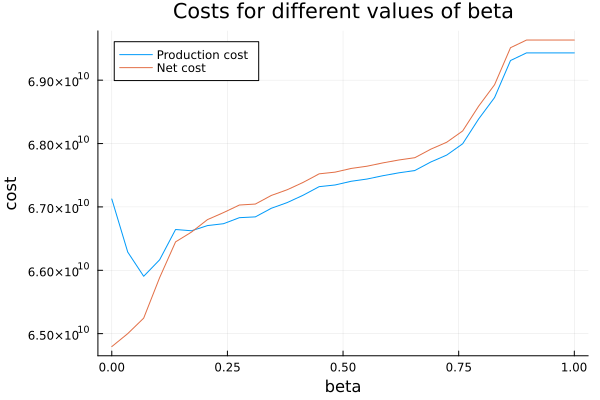

In [40]:
# plot the results, title on the top left, x axis on the bottom, y axis on the left
p = plot(betas_df.beta, betas_df.production_cost, label="Production cost", title="Costs for different values of beta", xlabel="beta", ylabel="cost", legend=:topleft)
plot!(p, betas_df.beta, betas_df.real_baseline_cost, label="Net cost")

# save the plot
#savefig(p, "sustainable_costs.png")

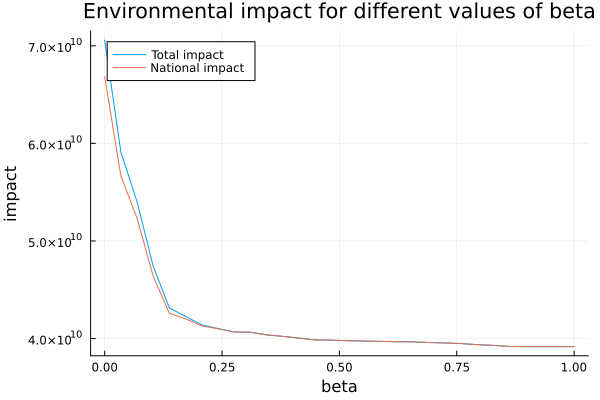

In [43]:
p2 = plot(betas_df.beta, betas_df.total_impact, label="Total impact", title="Environmental impact for different values of beta", xlabel="beta", ylabel="impact", legend=:topleft)
plot!(p2, betas_df.beta, betas_df.national_impact, label="National impact")

# save the plot
#savefig(p2, "sustainable_impact.png")

In [45]:
# plot the total cost depending on the total impact
p3 = plot(betas_df.total_impact, betas_df.real_baseline_cost, label="Net cost", title="Net cost depending on the total impact", xlabel="Total impact", ylabel="Net cost", legend=:topleft)

# save the plot
#savefig(p3, "sustainable_cost_impact.png")

"/Users/oscarcourbit/Desktop/Bureau - MacBook Pro de Oscar/MIT/Classes/15.093 -  Optimization Methods/Term Project/Energy-Allocation-in-France/sustainable_cost_impact.png"

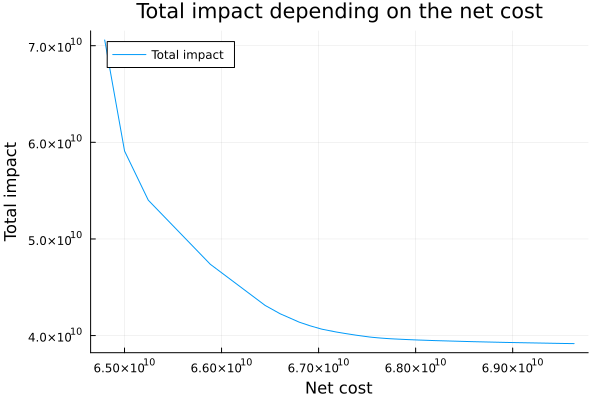

In [47]:
# plot the total impact depending on the total cost
p4 = plot(betas_df.real_baseline_cost, betas_df.total_impact, label="Total impact", title="Total impact depending on the net cost", xlabel="Net cost", ylabel="Total impact", legend=:topleft)

# save the plot
#savefig(p4, "sustainable_impact_cost.png")

### Results

In [49]:
# create a dataframe with total cost, production cost, total impact and national impact,
# for the RTE solution, the baseline solution, the crisis solution with alpha = 0.5 and the sustainable solution with beta = 0.2

df_costs = DataFrame(cost = Float64[], production_cost = Float64[], total_impact = Float64[], national_impact = Float64[], solution = String[])
push!(df_costs, (total_cost_rte, production_cost_rte, total_impact_rte, national_impact_rte, "RTE"))
push!(df_costs, (real_baseline_cost(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline), compute_production_cost(x_opt_baseline, df_baseline), compute_total_impact(x_opt_baseline, y_opt_baseline, df_baseline), compute_national_impact(x_opt_baseline, y_opt_baseline, z_opt_baseline, df_baseline), "Baseline"))

# compute the optimal solution for the crisis with alpha = 0.5
model_crisis = crisis_optimizer(df_baseline, 0.5)
x_opt_crisis = value.(model_crisis[:x])
y_opt_crisis = value.(model_crisis[:y])
z_opt_crisis = value.(model_crisis[:z])
push!(df_costs, (real_baseline_cost(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_baseline), compute_production_cost(x_opt_crisis, df_baseline), compute_total_impact(x_opt_crisis, y_opt_crisis, df_baseline), compute_national_impact(x_opt_crisis, y_opt_crisis, z_opt_crisis, df_baseline), "Crisis"))

# compute the optimal solution for the sustainable solution with beta = 0.2
model_sustainable = sustainable_optimizer(df_baseline, 0.15)
x_opt_sustainable = value.(model_sustainable[:x])
y_opt_sustainable = value.(model_sustainable[:y])
z_opt_sustainable = value.(model_sustainable[:z])
push!(df_costs, (real_baseline_cost(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline), compute_production_cost(x_opt_sustainable, df_baseline), compute_total_impact(x_opt_sustainable, y_opt_sustainable, df_baseline), compute_national_impact(x_opt_sustainable, y_opt_sustainable, z_opt_sustainable, df_baseline), "Sustainable"))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-18


Row,cost,production_cost,total_impact,national_impact,solution
,Float64,Float64,Float64,Float64,String
1,7.16813e10,7.9828e10,8.13053e10,7.24489e10,RTE
2,6.47958e10,6.7125e10,7.05921e10,6.6853e10,Baseline
3,6.49619e10,7.02839e10,7.24938e10,6.63907e10,Crisis
4,6.65241e10,6.66516e10,4.26764e10,4.22593e10,Sustainable


In [57]:
# export the dataframe to a csv file
#CSV.write("df_costs_3.csv", df_costs)

In [51]:
# plot the results, title on the top left, x axis on the bottom, y axis on the left
p5 = plot(df_costs.solution, df_costs.cost, label="Total cost", title="Total cost for different solutions", xlabel="Solution", ylabel="Total cost", legend=:topleft)
plot!(p5, df_costs.solution, df_costs.production_cost, label="Production cost")

# plot as a bar, first production_cost, then total_cost
p5 = bar(df_costs.solution, [df_costs.production_cost df_costs.cost], label=["Production cost" "Net cost"], title="Costs for different solutions", xlabel="Solution", ylabel="Cost", legend=:topright)

# save the plot
#savefig(p5, "solutions_costs.png")

"/Users/oscarcourbit/Desktop/Bureau - MacBook Pro de Oscar/MIT/Classes/15.093 -  Optimization Methods/Term Project/Energy-Allocation-in-France/solutions_costs.png"

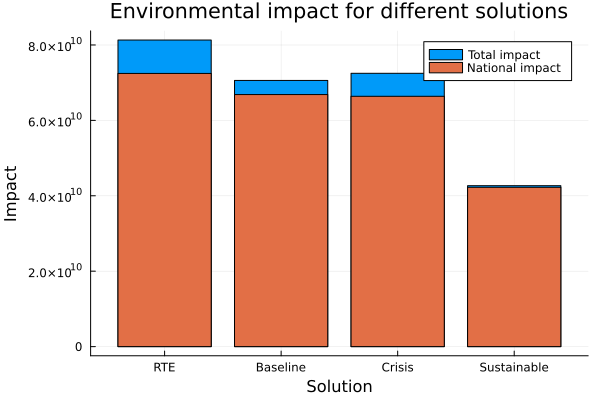

In [53]:
# plot the total impact depending on the total cost
p6 = plot(df_costs.solution, df_costs.total_impact, label="Total impact", title="Total impact for different solutions", xlabel="Solution", ylabel="Total impact", legend=:topleft)
plot!(p6, df_costs.solution, df_costs.national_impact, label="National impact")

# plot the bar 
p6 = bar(df_costs.solution, [df_costs.total_impact df_costs.national_impact], label=["Total impact" "National impact"], title="Environmental impact for different solutions", xlabel="Solution", ylabel="Impact", legend=:topright)

# save the plot
#savefig(p6, "solutions_impact.png")